# Creating meshes

Sometimes it's easy to mesh a domain. If the domain is convex we could simply compute the Delaunay triangulation of the boundary points.

In [3]:
import nbimporter
from lesson1 import *

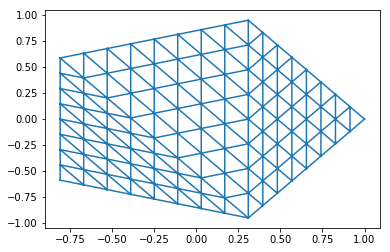

In [37]:
import numpy as np
from scipy.spatial import Delaunay

%matplotlib inline

# create boundary points
x = np.cos(np.linspace(0, 2*np.pi, 5, endpoint=False))
y = np.sin(np.linspace(0, 2*np.pi, 5, endpoint=False))

p = np.vstack((x, y))
# use SciPy interface to Qhull
t = Delaunay(p.T).simplices.copy().T

# refine a couple of times
for itr in range(3):
    p, t = refine_tri(p, t)

draw_tri(p, t)

Sometimes it's possible to glue simple meshes together. Let's make a function which glues nodes together.

In [55]:
def glue_tri(p1, t1, p2, t2):
    """Glue two meshes together: join duplicate points."""
    p = np.hstack((p1, p2))
    t = np.hstack((t1, t2 + p1.shape[1]))
    
    tmp = np.ascontiguousarray(p.T)
    tmp, ixa, ixb = np.unique(tmp.view([('', tmp.dtype)] * tmp.shape[1]),
                              return_index=True, return_inverse=True)
    p = p[:, ixa]
    t = ixb[t]
    return p, t

This makes it possible, for example, to quickly build a mesh for L-shaped domain.

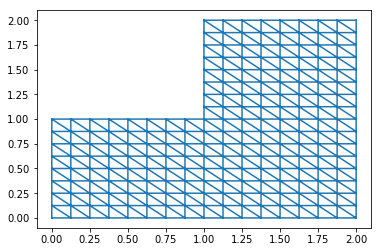

In [58]:
p = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
t = np.array([[0, 1, 2], [1, 2, 3]]).T

p, t = glue_tri(
    *glue_tri(p, t, p + np.array([1, 0])[:, None], t),
    p + np.array([1, 1])[:, None], t)

# refine a couple of times
for itr in range(3):
    p, t = refine_tri(p, t)

draw_tri(p, t)

It is also convenient to be able to remove elements from a mesh.

In [61]:
def remove_tri(p, t, ix):
    """Removes elements from the mesh based on element index."""
    keep = np.setdiff1d(np.arange(t.shape[1]), ix)
    t_ = t[:, keep]
    pix = np.unique(t_)
    reverse = np.zeros(p.shape[1])
    reverse[pix] = np.arange(len(pix))
    t_ = reverse[t_]
    p_ = p[:, pix]
    return p_, t_

In order to use *remove_elements* we need a function to query elements based on their spatial position. Let us write a function to find element indices based on their midpoints.

In [73]:
def find_tri(p, t, query):
    """Find the indices of triangles whose midpoints
    return true from the query function."""
    mx = .333333*np.sum(p[0, t], axis=0)
    my = .333333*np.sum(p[1, t], axis=0)
    return np.nonzero(query(mx, my))[0]

Now we can easily build a square mesh with a hole in the middle.

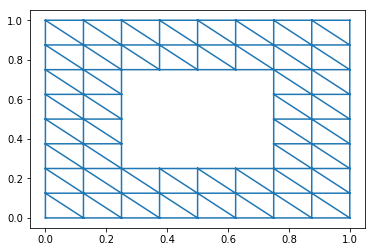

In [72]:
# square mesh
p = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
t = np.array([[0, 1, 2], [1, 2, 3]]).T

# refine
for itr in range(3):
    p, t = refine_tri(p, t)

#
p, t = remove_tri(p, t, find_tri(p, t, lambda x, y: (x<0.75)*(x>0.25)*(y<0.75)*(y>0.25)))
    
draw_tri(p, t)

Of course for real stuff you want to use mesh generators. Here is a list with some free ones:

- Triangle
- Tetgen
- Netgen
- Gmsh
- JIGSAW